In [1]:
import wfdb
import os
import numpy as np
import pandas as pd
import wfdb.processing as wp
import matplotlib.pyplot as plt
from scipy import signal
from utils import find_noise_features, extract_basic_features
import warnings
import shutil

import time
from lightgbm import LGBMClassifier
from scipy import sparse
from sklearn.metrics import f1_score
from sklearn.model_selection import KFold,StratifiedKFold
from xgboost import XGBClassifier
import matplotlib.pyplot as plt

warnings.filterwarnings('ignore')
path = "F:\\ECG数据集\\www.physionet.org\\physiobank\\database\\afdb\\"
record_name = "04048"

In [2]:
def cinc_f1_score(ref, ans, verbose=True, details=False):
    assert (ref.shape[0] == ans.shape[0])

    AA = np.zeros((4, 4))

    for n in range(ref.shape[0]):
        rec = ref[n]

        this_answer = ans[n]

        if rec == 0:
            if this_answer == 0:
                AA[0, 0] += 1
            elif this_answer == 1:
                AA[0, 1] += 1
            elif this_answer == 2:
                AA[0, 2] += 1
            elif this_answer == 3:
                AA[0, 3] += 1

        elif rec == 1:
            if this_answer == 0:
                AA[1, 0] += 1
            elif this_answer == 1:
                AA[1, 1] += 1
            elif this_answer == 2:
                AA[1, 2] += 1
            elif this_answer == 3:
                AA[1, 3] += 1

        elif rec == 2:
            if this_answer == 0:
                AA[2, 0] += 1
            elif this_answer == 1:
                AA[2, 1] += 1
            elif this_answer == 2:
                AA[2, 2] += 1
            elif this_answer == 3:
                AA[2, 3] += 1

        elif rec == 3:
            if this_answer == 0:
                AA[3, 0] += 1
            elif this_answer == 1:
                AA[3, 1] += 1
            elif this_answer == 2:
                AA[3, 2] += 1
            elif this_answer == 3:
                AA[3, 3] += 1

    F1n = 2 * AA[0, 0] / (sum(AA[0, :]) + sum(AA[:, 0]))
    F1a = 2 * AA[1, 1] / (sum(AA[1, :]) + sum(AA[:, 1]))
    F1o = 2 * AA[2, 2] / (sum(AA[2, :]) + sum(AA[:, 2]))
    F1p = 2 * AA[3, 3] / (sum(AA[3, :]) + sum(AA[:, 3]))
    F1 = (F1n + F1a + F1o) / 3
    if details:
        print(AA)
    if verbose:
        print('F1 measure for Normal rhythm: ' '%1.4f' % F1n)
        print('F1 measure for AF rhythm: ' '%1.4f' % F1a)
        print('F1 measure for Other rhythm: ' '%1.4f' % F1o)
        print('F1 measure for Noisy recordings: ' '%1.4f' % F1p)
        print('Final F1 measure: ' '%1.4f' % F1)

    return F1n,F1a,F1o,F1p,F1

In [3]:
import shutil
import os
def getFileName(base_path):
    f_list = os.listdir(base_path)
    file_temp = []
    # print f_list
    for i in f_list:
        if os.path.isdir(os.path.join(base_path,i)):
            files = os.listdir(os.path.join(base_path,i))
            for file in files:
                # os.path.splitext():分离文件名与扩展名
                if os.path.splitext(file)[1] == '.txt':
                    print(file)
                    file_path = os.path.join(base_path,i)+"\\"+file
                    print(file_path)
                    newfile_path = os.path.join(base_path,"results",i)+"\\"+"afdb_188features_lead1.txt"
                    print(newfile_path)
                    if not os.path.exists(os.path.join(base_path,"results",i)):   
                        os.makedirs(os.path.join(base_path,"results",i))
                        
                    shutil.copyfile(file_path,newfile_path)
                    
                    print(file)#file_temp.append(i.split(".")[0])
    return file_temp
#getFileName("F:\\ECG\\2017挑战赛ECG论文\\dawid-smolen-206\\AFdb_TEST1\\")

In [4]:
feature38_name = ['CV','rmssd','QRS_Width_std','MAD','AFEv','IrrEv','OriginCount','PACEv','R_amp_std','RR_mean',
           'RR_min','HR_median','RR_max','CV_deltaRR','Pf_1','Pf_2','pf_RR_1','pf_RR_2','pf_RR_3','se', 
           'nn50', 'percentage_nn50', 'arrhyth_ind', 'res_kstest','COSEn', 'Radius','similar_ind_QRS','similar_ind_Ramp',
           'r_high_similarbeats','stepping', 'E','MOBILITY','COMPLEXITY','R_amp_CV', 'QRS_width_mean','sk_RR','kurt_RR','RR_range']
feature16_name=[]
for i in [6,5,26,25,22,30,24,36,20,7,32,1,33,12,21,29]:
    feature16_name.append(feature38_name[i-1])
feature39_name = [
    "var", "skew", "kurtosis", "perdiogram_1", "perdiogram_2", "perdiogram_3",
    "perdiogram_4", "qrs_areas_mean", "qrs_areas_max", "qrs_areas2_mean",
    "qrs_areas2_max", "qrs_malin_mean", "qrs_malin_max", "qrs_malin2_mean",
    "qrs_malin2_max", "n_plus_mean", "n_plus_max", "n_plus2_mean",
    "n_plus2_max", "v40_mean", "v40_max", "v40_2_mean", "v40_2_max",
    "freq_ratio_1", "freq_ratio_2", "freq_ratio_3", "freq_ratio_4",
    "freq_ratio_5", "lorenz_plot", "rr_var", "rr_var_1", "rr_var_2", "log_rr",
    "log_rr_1_abs", "sample_entropy_1", "sample_entropy_2",
    "shannon_entropy_1", "shannon_entropy_2", "correlation"
]
def generate_feature188():
    a="Features_SD_1"
    feature_name = []
    feature_sd_name = []
    for i in range(1,69,1):
        b=a.replace(str(i),str(i+1))
        feature_name.append(a)
        feature_sd_name.append(a)
        a=b

    a="Features_RB_1"
    for i in range(1,16,1):
        b=a.replace(str(i),str(i+1))
        feature_name.append(a)
        a=b

    a="Features_ADC_1"
    feature_adc_name = []
    for i in range(1,22,1):
        b=a.replace(str(i),str(i+1))
        feature_name.append(a)
        feature_adc_name.append(a)
        a=b

    a='Features_embcsoa_1'
    for i in range(1,9,1):
        b=a.replace(str(i),str(i+1))
        feature_name.append(a)
        a=b

    a="Features_CP_1"
    for i in range(1,28,1):
        b=a.replace(str(i),str(i+1))
        feature_name.append(a)
        a=b

    a='features_temp_1'
    for i in range(1,20,1):
        b=a.replace(str(i),str(i+1))
        feature_name.append(a)
        a=b

    a='features_temp_rs_1'
    for i in range(1,31,1):
        b=a.replace(str(i),str(i+1))
        feature_name.append(a)
        a=b
    return feature_name,feature_sd_name,feature_adc_name
feature188_name,feature_sd_name,feature_adc_name= generate_feature188()

In [5]:
path = "F:\\ECG\\ecg\\training2017\\"
f_list = os.listdir(path)
file_list = []
for i in f_list:
    # os.path.splitext():分离文件名与扩展名
    if os.path.splitext(i)[1] == '.mat':
        file_list.append(i.split(".")[0])

In [6]:
#读取39个特征数据
if os.path.isfile("cinc_feat.csv"):
    features39_pd = pd.read_csv("cinc_feat.csv")
features39_pd.head()

,id,var,skew,kurtosis,perdiogram_1,perdiogram_2,perdiogram_3,perdiogram_4,qrs_areas_mean,qrs_areas_max,...,rr_var,rr_var_1,rr_var_2,log_rr,log_rr_1_abs,sample_entropy_1,sample_entropy_2,shannon_entropy_1,shannon_entropy_2,correlation
0,A00001,0.000111,2.909595,11.207767,-5022.949108,-4897.418491,-6417.626901,-8600.342510,0.348011,0.602488,...,0.000049,0.000022,0.000044,11.201408,0.781425,3.782768,2.772589,4.504121,4.499598,0.006479
1,A00002,0.000111,2.935605,15.180122,-4976.180846,-4776.655937,-6577.618563,-8395.064863,0.295944,0.919263,...,0.001101,0.002392,0.008281,9.144809,2.459695,1.916463,1.592631,4.640224,4.694019,0.117561
2,A00003,0.000056,-1.580090,4.994374,-10358.327470,-10455.589720,-14087.272830,-18263.731720,-0.091824,0.200487,...,0.000146,0.000197,0.000517,19.644293,2.044110,2.211211,1.800493,5.167088,5.119668,0.025986
3,A00004,0.000111,3.551206,14.768413,-4898.854941,-4707.588663,-6478.057380,-8517.461309,0.415471,0.506781,...,0.001151,0.001939,0.005273,9.152490,3.104567,2.984304,2.890372,4.640224,4.789015,0.038117
4,A00005,0.000056,2.303823,8.327276,-10835.293760,-10181.270340,-13613.273700,-17518.596880,0.119709,0.540239,...,0.001371,0.001967,0.004816,22.598280,10.004504,2.332943,1.735189,6.079932,6.396046,0.026922


In [7]:
#读取188个特征数据
path = "F:\\ECG\\ecg\\training2017\\"
if os.path.isfile("cinc_feat188.csv"):
    features188_pd = pd.read_csv("cinc_feat188.csv")
else:
    data = np.loadtxt(path+"TH902_features_188.txt")
    features188_pd = pd.DataFrame(data,columns=feature188_name,index=file_list)
     
    features188_pd['id']=file_list
    col = feature188_name.copy()
    col.insert(0,'id')
    #features15_pd = features15_pd.reindex(columns=col)
    features188_pd.to_csv("cinc_feat188.csv",index=False)
features188_pd.head()

,Features_SD_1,Features_SD_2,Features_SD_3,Features_SD_4,Features_SD_5,Features_SD_6,Features_SD_7,Features_SD_8,Features_SD_9,Features_SD_10,...,features_temp_rs_22,features_temp_rs_23,features_temp_rs_24,features_temp_rs_25,features_temp_rs_26,features_temp_rs_27,features_temp_rs_28,features_temp_rs_29,features_temp_rs_30,id
0,-11.0,11.0,0.0,0.0,0.0,0.0,0.044264,0.031529,0.039185,0.013482,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,A00001
1,9.0,7.0,16.0,0.0,0.0,4.0,0.325171,0.296396,0.298329,0.171309,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,A00002
2,-26.0,31.0,5.0,0.0,0.0,3.0,0.093895,0.088135,0.064279,0.056015,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,A00003
3,26.0,0.0,26.0,0.0,1.0,5.0,0.195561,0.251051,0.318723,0.107943,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,A00004
4,57.0,10.0,75.0,4.0,9.0,15.0,0.412665,0.503457,0.537868,0.263645,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,A00005


In [8]:
path = "./wclfeature/"
features38_pd = pd.read_csv(path+"cinc_feat.csv",header=None)
features38_pd.drop([0,39],axis=1,inplace=True)
features38_pd.columns = feature38_name
features38_pd['id']=file_list
features38_pd.head()

,CV,rmssd,QRS_Width_std,MAD,AFEv,IrrEv,OriginCount,PACEv,R_amp_std,RR_mean,...,stepping,E,MOBILITY,COMPLEXITY,R_amp_CV,QRS_width_mean,sk_RR,kurt_RR,RR_range,id
0,0.04,0.00,0.00,0.03,-6.0,0.0,6.0,0.0,0.09,0.76,...,0.04,11.90,0.16,9.03,0.11,0.07,0.12,1.80,0.11,A00001
1,0.04,0.00,0.00,0.03,-6.0,0.0,6.0,0.0,0.07,1.03,...,0.04,-0.95,0.24,5.89,0.10,0.07,-0.41,2.62,0.13,A00002
2,0.10,0.01,0.01,0.04,-14.0,8.0,22.0,0.0,0.12,0.74,...,0.11,21.17,0.20,8.28,-0.26,0.07,0.18,11.10,0.61,A00003
3,0.19,0.06,0.00,0.15,26.0,26.0,0.0,0.0,0.11,0.95,...,0.32,0.12,0.30,5.23,0.09,0.07,0.48,2.05,0.62,A00004
4,0.41,0.07,0.01,0.18,58.0,76.0,8.0,5.0,0.16,0.54,...,0.53,28.54,0.48,3.29,0.17,0.06,1.18,3.02,0.78,A00005


In [9]:
#组合全部特征
train_data = pd.merge(features188_pd,features38_pd,on='id')
train_data = pd.merge(train_data,features39_pd,on='id')
train_data.head()

,Features_SD_1,Features_SD_2,Features_SD_3,Features_SD_4,Features_SD_5,Features_SD_6,Features_SD_7,Features_SD_8,Features_SD_9,Features_SD_10,...,rr_var,rr_var_1,rr_var_2,log_rr,log_rr_1_abs,sample_entropy_1,sample_entropy_2,shannon_entropy_1,shannon_entropy_2,correlation
0,-11.0,11.0,0.0,0.0,0.0,0.0,0.044264,0.031529,0.039185,0.013482,...,0.000049,0.000022,0.000044,11.201408,0.781425,3.782768,2.772589,4.504121,4.499598,0.006479
1,9.0,7.0,16.0,0.0,0.0,4.0,0.325171,0.296396,0.298329,0.171309,...,0.001101,0.002392,0.008281,9.144809,2.459695,1.916463,1.592631,4.640224,4.694019,0.117561
2,-26.0,31.0,5.0,0.0,0.0,3.0,0.093895,0.088135,0.064279,0.056015,...,0.000146,0.000197,0.000517,19.644293,2.044110,2.211211,1.800493,5.167088,5.119668,0.025986
3,26.0,0.0,26.0,0.0,1.0,5.0,0.195561,0.251051,0.318723,0.107943,...,0.001151,0.001939,0.005273,9.152490,3.104567,2.984304,2.890372,4.640224,4.789015,0.038117
4,57.0,10.0,75.0,4.0,9.0,15.0,0.412665,0.503457,0.537868,0.263645,...,0.001371,0.001967,0.004816,22.598280,10.004504,2.332943,1.735189,6.079932,6.396046,0.026922


In [10]:
#读取标签
path = "F:\\ECG\\ecg\\training2017\\"
target = pd.read_csv(os.path.join(path,"REFERENCE-v3.csv"),header=None,index_col=False)
target.columns=["ID","label"]
target.head()

,ID,label
0,A00001,N
1,A00002,N
2,A00003,N
3,A00004,A
4,A00005,A


In [11]:
train_data["label"] = np.array(target["label"])#target["label"]
train_data.head()

,Features_SD_1,Features_SD_2,Features_SD_3,Features_SD_4,Features_SD_5,Features_SD_6,Features_SD_7,Features_SD_8,Features_SD_9,Features_SD_10,...,rr_var_1,rr_var_2,log_rr,log_rr_1_abs,sample_entropy_1,sample_entropy_2,shannon_entropy_1,shannon_entropy_2,correlation,label
0,-11.0,11.0,0.0,0.0,0.0,0.0,0.044264,0.031529,0.039185,0.013482,...,0.000022,0.000044,11.201408,0.781425,3.782768,2.772589,4.504121,4.499598,0.006479,N
1,9.0,7.0,16.0,0.0,0.0,4.0,0.325171,0.296396,0.298329,0.171309,...,0.002392,0.008281,9.144809,2.459695,1.916463,1.592631,4.640224,4.694019,0.117561,N
2,-26.0,31.0,5.0,0.0,0.0,3.0,0.093895,0.088135,0.064279,0.056015,...,0.000197,0.000517,19.644293,2.044110,2.211211,1.800493,5.167088,5.119668,0.025986,N
3,26.0,0.0,26.0,0.0,1.0,5.0,0.195561,0.251051,0.318723,0.107943,...,0.001939,0.005273,9.152490,3.104567,2.984304,2.890372,4.640224,4.789015,0.038117,A
4,57.0,10.0,75.0,4.0,9.0,15.0,0.412665,0.503457,0.537868,0.263645,...,0.001967,0.004816,22.598280,10.004504,2.332943,1.735189,6.079932,6.396046,0.026922,A


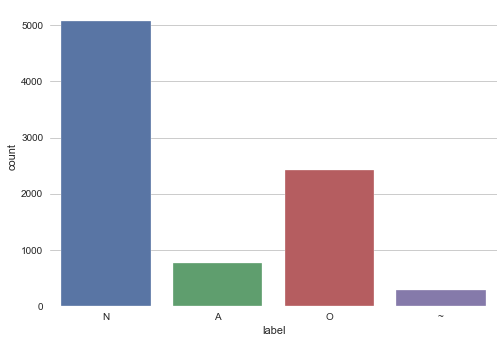

In [12]:
import seaborn as sns
warnings.filterwarnings('ignore')
%matplotlib inline
plt.style.use('seaborn')
pd.set_option('display.float_format', lambda x: '%.8f' % x)

sns.set_style('whitegrid')
sns.countplot(train_data[train_data['E'].notnull()].reset_index()["label"])

In [13]:
train_df = train_data[train_data['E'].notnull()].reset_index()

train_labels = train_df['label']
map_dict = {"N":0,"A":1,"O":2,"~":3}
train_labels = train_labels.map(map_dict)
train_df["label"] = train_labels.values#target["label"]
train_df.head()

,index,Features_SD_1,Features_SD_2,Features_SD_3,Features_SD_4,Features_SD_5,Features_SD_6,Features_SD_7,Features_SD_8,Features_SD_9,...,rr_var_1,rr_var_2,log_rr,log_rr_1_abs,sample_entropy_1,sample_entropy_2,shannon_entropy_1,shannon_entropy_2,correlation,label
0,0,-11.00000000,11.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.04426400,0.03152900,0.03918500,...,0.00002230,0.00004430,11.20140801,0.78142460,3.78276817,2.77258872,4.50412060,4.49959762,0.00647882,0
1,1,9.00000000,7.00000000,16.00000000,0.00000000,0.00000000,4.00000000,0.32517100,0.29639600,0.29832900,...,0.00239223,0.00828122,9.14480873,2.45969485,1.91646295,1.59263079,4.64022393,4.69401936,0.11756109,0
2,2,-26.00000000,31.00000000,5.00000000,0.00000000,0.00000000,3.00000000,0.09389500,0.08813500,0.06427900,...,0.00019736,0.00051699,19.64429350,2.04411026,2.21121082,1.80049315,5.16708805,5.11966798,0.02598626,0
3,3,26.00000000,0.00000000,26.00000000,0.00000000,1.00000000,5.00000000,0.19556100,0.25105100,0.31872300,...,0.00193868,0.00527312,9.15248984,3.10456705,2.98430358,2.89037176,4.64022393,4.78901548,0.03811713,1
4,4,57.00000000,10.00000000,75.00000000,4.00000000,9.00000000,15.00000000,0.41266500,0.50345700,0.53786800,...,0.00196747,0.00481638,22.59828023,10.00450437,2.33294272,1.73518912,6.07993157,6.39604595,0.02692229,1


In [14]:
train_df.shape

(8528, 268)

In [105]:
feature_name = ['sk_RR',
 'Features_SD_55',
 'features_temp_11',
 'pf_RR_1',
 'Features_SD_22',
 'Features_SD_48',
 'Features_embcsoa_8',
 'qrs_malin2_max',
 'Features_ADC_9',
 'Features_SD_16',
 'sample_entropy_2',
 'n_plus_mean',
 'RR_min',
 'Features_SD_47',
 'Features_SD_13',
 'CV_deltaRR',
 'Features_CP_15',
 'sample_entropy_1',
 'features_temp_2',
 'AFEv',
 'se',
 'r_high_similarbeats',
 'qrs_malin_max',
 'v40_mean',
 'Features_SD_64',
 'Features_CP_18',
 'rr_var_2',
 'Features_ADC_6',
 'features_temp_rs_13',
 'qrs_malin_mean',
 'features_temp_rs_15',
 'Features_RB_6',
 'lorenz_plot',
 'qrs_malin2_mean',
 'Features_SD_57',
 'Features_SD_14',
 'Features_CP_17',
 'Features_RB_4',
 'features_temp_rs_7',
 'Features_SD_52',
 'Features_CP_12',
 'Features_SD_33',
 'Features_ADC_2',
 'Features_SD_44',
 'features_temp_rs_2',
 'Features_SD_1',
 'Features_SD_58',
 'features_temp_rs_8',
 'features_temp_rs_17',
 'Features_SD_41',
 'Features_CP_4',
 'R_amp_CV',
 'Features_RB_11',
 'Features_SD_37',
 'Radius',
 'Features_SD_46',
 'Features_ADC_13',
 'Features_CP_8',
 'Features_CP_22',
 'Features_SD_60',
 'IrrEv',
 'features_temp_12',
 'Features_RB_10',
 'kurt_RR',
 'Features_SD_28',
 'Features_SD_59',
 'Features_CP_7',
 'perdiogram_1',
 'features_temp_rs_16',
 'Features_SD_35',
 'Features_SD_51',
 'v40_2_mean',
 'Features_CP_26',
 'Features_ADC_10',
 'Features_RB_13',
 'Features_SD_45',
 'Features_CP_25',
 'COSEn',
 'Features_SD_43',
 'Features_RB_9',
 'Features_SD_42',
 'Features_SD_38',
 'Features_RB_8',
 'Features_ADC_3',
 'n_plus2_mean',
 'features_temp_rs_1',
 'Features_SD_39',
 'Features_RB_14',
 'Features_CP_14',
 'Features_CP_19',
 'Features_CP_16',
 'Features_SD_36',
 'Features_RB_12',
 'RR_max',
 'Features_SD_56',
 'Features_CP_20',
 'Features_SD_62',
 'features_temp_3',
 'features_temp_rs_10',
 'HR_median'][:30]

len(feature_name)#43：0.8132 0.8232    48：0.8143 -0.8260  51 0.8088-0.8233
#feature_name = feature39_name+feature38_name+feature_adc_name+feature_sd_name#feature188_name[:175]
#feature_name = feature16_name
len(feature_name)

30

In [106]:
feature_name = list(set(feature_name + feature16_name))
len(feature_name)

42

In [107]:
feature_name =  list(set(feature_name)-{'n_plus_mean',"qrs_malin2_max",'features_temp_11','Features_embcsoa_8','pf_RR_1',
                                        'res_kstest','Features_CP_15',
                                        'v40_mean','features_temp_rs_13','qrs_malin_max','qrs_malin_mean','v40_mean',
                                        'features_temp_2','Features_SD_16','Features_SD_14','Features_SD_22','OriginCount', 'MOBILITY'
                                        }|
                     {'lorenz_plot','Features_ADC_6','Features_ADC_10'})#,'rr_var_2' ,'Features_SD_14'
                        #'Features_SD_44','Features_SD_33',"log_rr_1_abs" Features_ADC_11
    #'Features_SD_42',
    #'rr_var_2',
    #'Features_SD_1',
    #'Features_ADC_13',
    #'Features_ADC_3',
    #'Features_SD_58',
    #'Features_SD_38',
feature_name

#len(feature_name)

['Radius',
 'sample_entropy_2',
 'Features_SD_13',
 'IrrEv',
 'HR_median',
 'COMPLEXITY',
 'RR_min',
 'se',
 'r_high_similarbeats',
 'percentage_nn50',
 'Features_SD_64',
 'Features_SD_47',
 'Features_ADC_9',
 'COSEn',
 'AFEv',
 'CV',
 'lorenz_plot',
 'Features_ADC_6',
 'CV_deltaRR',
 'stepping',
 'Features_ADC_10',
 'Features_SD_48',
 'rr_var_2',
 'Features_SD_55',
 'nn50',
 'Features_CP_18',
 'sk_RR',
 'sample_entropy_1']

In [68]:
feature_name_pre=['Radius',
 'sample_entropy_2',
 'features_temp_2',
 'sk_RR',
 'Features_SD_22',
 'IrrEv',
 'Features_SD_13',
 'HR_median',
 'COMPLEXITY',
 'se',
 'r_high_similarbeats',
 'percentage_nn50',
 'OriginCount',
 'Features_SD_14',
 'Features_SD_47',
 'Features_ADC_9',
 'COSEn',
 'AFEv',
 'CV',
 'Features_SD_16',
 'CV_deltaRR',
 'lorenz_plot',
 'Features_ADC_6',
 'stepping',
 'Features_ADC_10',
 'Features_SD_48',
 'Features_SD_55',
 'nn50',
 'RR_min',
 'MOBILITY',
 'sample_entropy_1']


In [69]:
set(feature_name)-set(feature_name_pre)

{'Features_CP_18', 'Features_SD_64', 'rr_var_2'}

In [108]:
import lightgbm as lgb
lgb_params2={
 'learning_rate' : 0.01,
 'n_estimators':819,
 'max_depth':8,
 'num_leaves':115,
 'min_child_weight':0,
 'subsample':0.8,
 'colsample_bytree':0.8,
 'min_child_samples':21,
 'objective':'multiclass',
 'reg_alpha':0.15,
 'reg_lambda' : 0.01,
 'num_class': 4,
 'n_jobs':4,
 #class_weight ="1",
 'random_state' :27}

In [109]:
train_df[feature_name].shape

(8528, 28)

In [110]:
train_df[feature_name].describe()

,Radius,sample_entropy_2,Features_SD_13,IrrEv,HR_median,COMPLEXITY,RR_min,se,r_high_similarbeats,percentage_nn50,...,CV_deltaRR,stepping,Features_ADC_10,Features_SD_48,rr_var_2,Features_SD_55,nn50,Features_CP_18,sk_RR,sample_entropy_1
count,8528.00000000,8528.00000000,8528.00000000,8528.00000000,8528.00000000,8528.00000000,8528.00000000,8528.00000000,8528.00000000,8528.00000000,...,8528.00000000,8528.00000000,8528.00000000,8528.00000000,8528.00000000,8528.00000000,8528.00000000,8528.00000000,8528.00000000,8528.00000000
mean,0.07543856,1.66509864,0.83850122,5.65114916,72.93042800,7.06634029,0.69828330,2.53388954,0.89878401,0.73297608,...,28271612998510.56250000,0.10586069,297.93515478,0.36728078,0.00350397,0.29058893,26.05393996,0.53676441,-0.07349672,2.39622770
std,0.15229096,0.94230839,0.19624256,10.96315764,21.38764428,2.32543838,0.22092895,0.74464064,0.17168202,0.28984632,...,3982293868470710.00000000,0.14878298,274.55739645,0.22286919,0.00957162,1.18965139,17.28131871,0.14557858,1.17191924,0.70399734
min,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,...,-169097428538972992.00000000,0.00000000,0.00000000,0.00000000,0.00000000,-36.72056300,0.00000000,0.00000000,-8.76000000,0.00000000
25%,0.01000000,1.00318793,0.72500000,0.00000000,62.07000000,5.69750000,0.56000000,2.32000000,0.91000000,0.58000000,...,-22.23250000,0.02000000,233.00000000,0.22974775,0.00003900,0.16688725,14.00000000,0.44117600,-0.49000000,1.94741278
50%,0.03000000,1.73460105,0.83666700,1.00000000,70.87000000,7.29000000,0.72000000,2.82000000,0.96000000,0.87000000,...,4.22000000,0.04000000,267.00000000,0.32917800,0.00039367,0.24070600,25.00000000,0.54166700,0.00000000,2.51354221
75%,0.05000000,2.35137526,0.95000000,6.00000000,81.45000000,8.41000000,0.84000000,3.03000000,0.97000000,0.96000000,...,25.08250000,0.11000000,308.00000000,0.46029300,0.00327432,0.32346675,34.00000000,0.63636400,0.43000000,2.88776306
max,1.76000000,4.61512052,4.29000000,108.00000000,204.55000000,17.26000000,1.77000000,3.29000000,1.00000000,0.99000000,...,257330024218593088.00000000,1.15000000,17241.00000000,4.73705000,0.27260395,98.25690400,167.00000000,1.00000000,8.55000000,5.03043792


In [111]:
cv_pred_all = 0
en_amount = 1
for seed in range(en_amount):
    print("************************")
    NFOLDS = 10
    train_label = train_labels#train_data['score']
    train_data_df = train_df[feature_name].astype('float64') #feature_name  columns
    kfold = StratifiedKFold(n_splits=NFOLDS, shuffle=True, random_state=seed)
    kf = kfold.split(train_data_df, train_label)

    #train_data_use = train_data.drop(['uid','score','blk_list_flag'], axis=1)
    #test_data_use = test_data.drop(['uid','blk_list_flag'], axis=1)
    train_data_use = train_data_df
    # cv_pred = np.zeros(test_data.shape[0])
    valid_best_l2_all = 0
    oof = np.zeros(train_data_df.shape[0])
    feature_importance_df = pd.DataFrame()
    count = 0
    for i, (train_fold, validate) in enumerate(kf):
        print('fold: ',i, ' training')
        X_train, X_validate, label_train, label_validate = \
        train_data_use.iloc[train_fold, :], train_data_use.iloc[validate, :], \
        train_label[train_fold], train_label[validate]
        #print(X_validate)
        #break
        dtrain = lgb.Dataset(X_train, label_train)
        dvalid = lgb.Dataset(X_validate, label_validate, reference=dtrain)
        bst = lgb.train(lgb_params2, dtrain, num_boost_round=819, valid_sets=dvalid, verbose_eval=200,early_stopping_rounds=500)
        #cv_pred += bst.predict(test_data_use, num_iteration=bst.best_iteration)
        #valid_best_l2_all += bst.best_score['valid_0']['l1']
        k_pred = bst.predict(X_validate, num_iteration=bst.best_iteration)
        oof[validate] = np.argmax(k_pred,axis=1)
        fold_importance_df = pd.DataFrame()
        fold_importance_df["feature"] = list(X_train.columns)
        fold_importance_df["importance"] = bst.feature_importance(importance_type='split', iteration=bst.best_iteration)
        fold_importance_df["fold"] = count + 1
        feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
        count += 1

oof = list(map(int, oof))
fold_f1_error = f1_score(train_labels.values, oof, average='macro')
print('fold f1 score is {0}'.format(fold_f1_error))

F1n,F1a,F1o,F1p,F1 = cinc_f1_score(np.array(oof),np.array(train_labels.values))


************************
fold:  0  training
Training until validation scores don't improve for 500 rounds.
[200]	valid_0's multi_logloss: 0.526412
[400]	valid_0's multi_logloss: 0.427695
[600]	valid_0's multi_logloss: 0.411534
[800]	valid_0's multi_logloss: 0.409086
Did not meet early stopping. Best iteration is:
[808]	valid_0's multi_logloss: 0.408923
fold:  1  training
Training until validation scores don't improve for 500 rounds.
[200]	valid_0's multi_logloss: 0.549536
[400]	valid_0's multi_logloss: 0.457654
[600]	valid_0's multi_logloss: 0.442122
[800]	valid_0's multi_logloss: 0.444507
Did not meet early stopping. Best iteration is:
[603]	valid_0's multi_logloss: 0.442046
fold:  2  training
Training until validation scores don't improve for 500 rounds.
[200]	valid_0's multi_logloss: 0.56103
[400]	valid_0's multi_logloss: 0.469564
[600]	valid_0's multi_logloss: 0.454669
[800]	valid_0's multi_logloss: 0.455526
Did not meet early stopping. Best iteration is:
[664]	valid_0's multi_logl

In [112]:
bst.save_model("lightgbm_05141_temp.bin")

In [26]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
def display_confusion_matrix(y_pred,y_true):
    # Creates a confusion matrix
    cm = confusion_matrix(y_true,y_pred)

    # Transform to df for easier plotting
    cm_df = pd.DataFrame(cm,
                         index = ['N','A','O','~'], 
                         columns = ['N','A','O','~'])

    plt.figure(figsize=(16,10))
    sns.heatmap(cm_df, annot=True,annot_kws={'size':25,'weight':'bold', 'color':'r'},fmt="d")#,cmap="RdBu"
    plt.title('Xgboost \nAccuracy:{0:.3f}'.format(accuracy_score(y_pred,y_true)))
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.show()

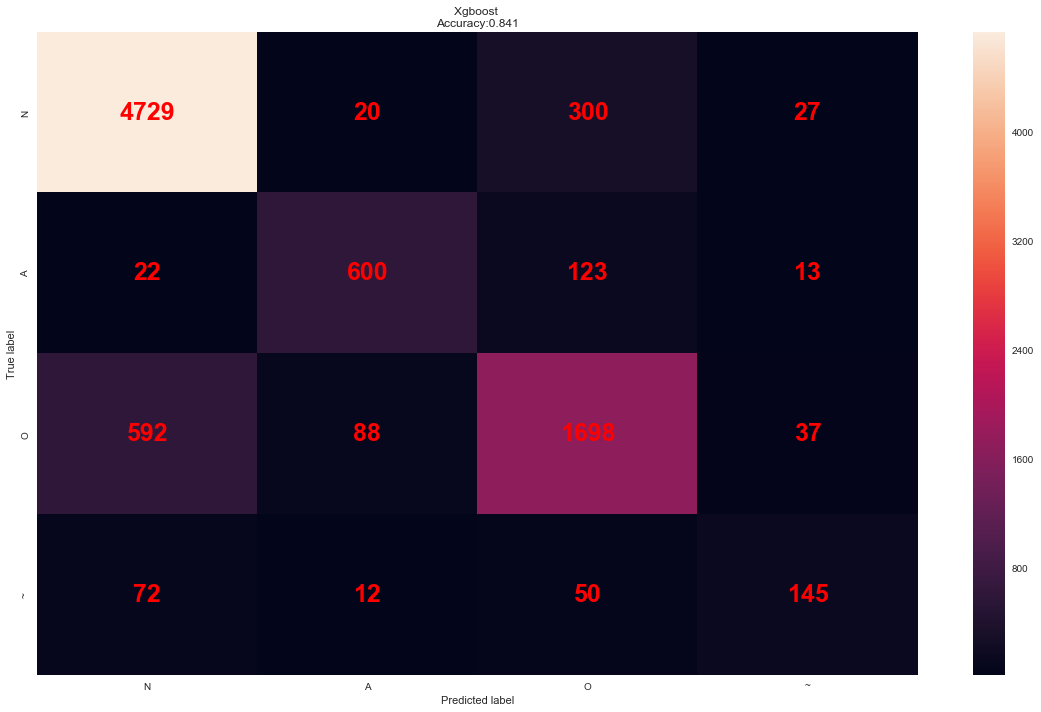

In [27]:
display_confusion_matrix(oof,train_labels.values)

In [28]:
def display_importances(model_name,feature_importance_df_):
    cols = feature_importance_df_[["feature", "importance"]].groupby("feature").mean().sort_values(by="importance", ascending=False)[:100].index
    best_features = feature_importance_df_.loc[feature_importance_df_.feature.isin(cols)]
    plt.figure(figsize=(12, 16))
    sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False))
    plt.title('{0} Features (avg over folds)'.format(model_name))
    plt.tight_layout()
    plt.show()
    
    return cols

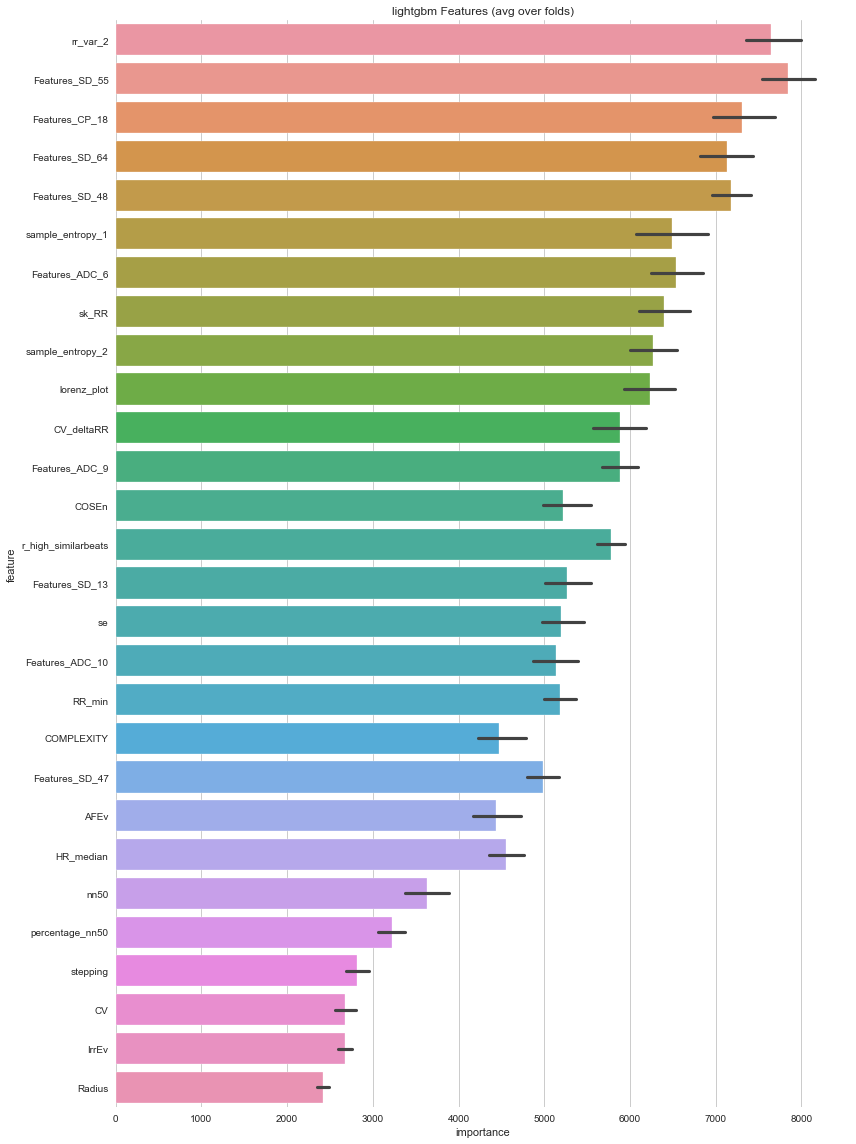

In [116]:
#feature_importance_df[["feature", "importance"]].groupby("feature").mean().sort_values(by="importance", ascending=False)[:200].index.tolist()
top_fea = display_importances("lightgbm",feature_importance_df)

In [104]:
feature_importance_df[["feature", "importance"]].groupby("feature").mean().sort_values(by="importance", ascending=False)[:100].index.tolist()

['Features_SD_55',
 'rr_var_2',
 'Features_CP_18',
 'Features_SD_64',
 'Features_SD_48',
 'sample_entropy_1',
 'Features_ADC_6',
 'sk_RR',
 'sample_entropy_2',
 'lorenz_plot',
 'Features_ADC_9',
 'CV_deltaRR',
 'r_high_similarbeats',
 'RR_min',
 'Features_SD_13',
 'se',
 'COSEn',
 'Features_ADC_10',
 'Features_SD_47',
 'HR_median',
 'COMPLEXITY',
 'AFEv',
 'nn50',
 'percentage_nn50',
 'stepping',
 'IrrEv',
 'CV',
 'Radius',
 'OriginCount',
 'MOBILITY']

## xgboost

In [134]:
import xgboost as xgb
start_time = time.time()
offline=0
online=0
params={'booster':'gbtree',
    'objective': 'rank:pairwise',
    'eval_metric':'auc',
    'gamma':0.1,
    'min_child_weight':1.1,
    'max_depth':7,
    'lambda':10,
    'subsample':0.7,
    'colsample_bytree':0.7,
    'colsample_bylevel':0.7,
    'eta': 0.01,
    'tree_method':'exact',
    'seed':1000,
    'nthread':12
    }

xgb_params2={
'booster':'gbtree',
'objective': 'multi:softmax',#'binary:logistic',
'num_class': 4,
'scale_pos_weight': 1/7.5,
#7183正样本
#55596条总样本
#差不多1:7.7这样子
'gamma':0.2,  # 用于控制是否后剪枝的参数,越大越保守，一般0.1、0.2这样子。
'max_depth':8, # 构建树的深度，越大越容易过拟合
'lambda':10,  # 控制模型复杂度的权重值的L2正则化项参数，参数越大，模型越不容易过拟合。
'subsample':0.7, # 随机采样训练样本
#'colsample_bytree':0.7, # 生成树时进行的列采样
'min_child_weight':3, 
# 这个参数默认是 1，是每个叶子里面 h 的和至少是多少，对正负样本不均衡时的 0-1 分类而言
#，假设 h 在 0.01 附近，min_child_weight 为 1 意味着叶子节点中最少需要包含 100 个样本。
#这个参数非常影响结果，控制叶子节点中二阶导的和的最小值，该参数值越小，越容易 overfitting。 
'silent':0 ,#设置成1则没有运行信息输出，最好是设置为0.
'eta': 0.03, # 如同学习率
'seed':1000,
'nthread':-1,# cpu 线程数
'eval_metric': 'mlogloss',#'auc'
}

xgb_params3={
 'learning_rate' :0.01,
 'n_estimators':2000,
 'max_depth':6,
 'min_child_weight':3,
 'gamma':0.2,
 'subsample':0.8,
 'colsample_bytree':0.8,
 'objective':'multi:softprob',#'binary:logistic',multi:softprob,multi:softmax
 'num_class': 4,
 'nthread':-1,
 'reg_alpha':0,
 'reg_lambda':1,
 'scale_pos_weight':1,
 'seed':27,
 'booster':'gbtree',
 #'scale_pos_weight': 1/7.5,
 #7183正样本
 #55596条总样本
 #差不多1:7.7这样子
 # 这个参数默认是 1，是每个叶子里面 h 的和至少是多少，对正负样本不均衡时的 0-1 分类而言
 #，假设 h 在 0.01 附近，min_child_weight 为 1 意味着叶子节点中最少需要包含 100 个样本。
 #这个参数非常影响结果，控制叶子节点中二阶导的和的最小值，该参数值越小，越容易 overfitting。 
 'silent':0 ,#设置成1则没有运行信息输出，最好是设置为0.
 'eval_metric': 'mlogloss',#'auc'
}

plst = list(xgb_params3.items())
num_rounds = 5000 # 迭代次数

#offline_test_X=offline_test[feature_list]
#online_test_X=online_test[feature_list]
cv_pred_all = 0
en_amount = 1
for seed in range(en_amount):
    print("************************")
    NFOLDS = 10
    train_label = train_labels#train_data['score']
    train_data = train_df[feature_name]
    kfold = StratifiedKFold(n_splits=NFOLDS, shuffle=True, random_state=seed)
    kf = kfold.split(train_data, train_label)

    #train_data_use = train_data.drop(['uid','score','blk_list_flag'], axis=1)
    #test_data_use = test_data.drop(['uid','blk_list_flag'], axis=1)
    train_data_use = train_data

    # cv_pred = np.zeros(test_data.shape[0])
    valid_best_l2_all = 0
    oof = np.zeros(train_df.shape[0])
    feature_importance_df = pd.DataFrame()
    count = 0
    for i, (train_fold, validate) in enumerate(kf):
        print('fold: ',i, ' training')
        X_train, X_validate, label_train, label_validate = \
        train_data_use.iloc[train_fold, :], train_data_use.iloc[validate, :], \
        train_label[train_fold], train_label[validate]
        
        xgb_train = xgb.DMatrix(X_train, label=label_train)
        xgb_val = xgb.DMatrix(X_validate,label=label_validate)
        
        # return 训练和验证的错误率
        watchlist = [(xgb_train, 'train'),(xgb_val, 'val')]

        # training model 
        # early_stopping_rounds 当设置的迭代次数较大时，early_stopping_rounds 可在一定的迭代次数内准确率没有提升就停止训练
        model = xgb.train(plst, xgb_train,num_boost_round=2000,evals=watchlist,early_stopping_rounds=500,verbose_eval=200)

        k_pred = model.predict(xgb_val, ntree_limit=model.best_iteration)
        oof[validate] = np.argmax(k_pred,axis=1)
        #fold_importance_df = pd.DataFrame()
        #fold_importance_df["feature"] = list(X_train.columns)
        #fold_importance_df["importance"] = model.feature_importance(importance_type='split', iteration=bst.best_iteration)
        #fold_importance_df["fold"] = count + 1
        #feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
        count += 1

oof = list(map(int, oof))
fold_f1_error = f1_score(train_labels.values, oof, average='macro')
print('fold f1 score is {0}'.format(fold_f1_error))

F1n,F1a,F1o,F1p,F1 = cinc_f1_score(np.array(oof),np.array(train_labels.values))

import json
import time
data = {
    'name' : 'xgboost',
    'seed mount': en_amount,
    'kfold': NFOLDS,
    'params':plst,
    'revise':"",
    'F1n' : F1n,
    'F1a' : F1a,
    'F1o' : F1o,
    'F1p' : F1p,
    'F1':F1
}
with open("xgb_record.json","a") as f:
    f.write(" \n\n{0}: \n ".format(time.strftime("%Y-%m-%d %H:%M:%S", time.localtime()) ))
    json.dump(data,f,indent=2)

************************
fold:  0  training
[0]	train-mlogloss:1.37383	val-mlogloss:1.37406
Multiple eval metrics have been passed: 'val-mlogloss' will be used for early stopping.

Will train until val-mlogloss hasn't improved in 500 rounds.
[200]	train-mlogloss:0.538175	val-mlogloss:0.579846
[400]	train-mlogloss:0.409228	val-mlogloss:0.49185
[600]	train-mlogloss:0.360056	val-mlogloss:0.476196
[800]	train-mlogloss:0.328202	val-mlogloss:0.47345
[1000]	train-mlogloss:0.303634	val-mlogloss:0.474026
[1200]	train-mlogloss:0.282347	val-mlogloss:0.475812
Stopping. Best iteration:
[826]	train-mlogloss:0.324776	val-mlogloss:0.473417

fold:  1  training
[0]	train-mlogloss:1.37372	val-mlogloss:1.37405
Multiple eval metrics have been passed: 'val-mlogloss' will be used for early stopping.

Will train until val-mlogloss hasn't improved in 500 rounds.
[200]	train-mlogloss:0.53605	val-mlogloss:0.590715
[400]	train-mlogloss:0.408405	val-mlogloss:0.507597
[600]	train-mlogloss:0.358465	val-mlogloss:0.49

# 随机森林

In [138]:
cv_pred_all = 0
en_amount = 1
from sklearn.ensemble import RandomForestClassifier

# print('rfc.score=',rfc.score(features_test[:,feat_rank], 1-labels_test))

#Perfmc_analysis(1-labels_test,ypred2)
# feat_rank = range(0,38)
for seed in range(en_amount):
    print("************************")
    NFOLDS = 10
    train_label = train_labels#train_data['score']
    train_data = train_df[feature_name]
    
    #train_df[feature_name].astype('float64') #feature_name  columns
    kfold = StratifiedKFold(n_splits=NFOLDS, shuffle=True, random_state=seed)
    kf = kfold.split(train_data_df, train_label)

    #train_data_use = train_data.drop(['uid','score','blk_list_flag'], axis=1)
    #test_data_use = test_data.drop(['uid','blk_list_flag'], axis=1)
    train_data_use = train_data_df
    # cv_pred = np.zeros(test_data.shape[0])
    valid_best_l2_all = 0
    oof = np.zeros(train_data_df.shape[0])
    feature_importance_df = pd.DataFrame()
    count = 0
    for i, (train_fold, validate) in enumerate(kf):
        print('fold: ',i, ' training')
        #print(validate)
        
        X_train, X_validate, label_train, label_validate = \
        train_data_use.iloc[train_fold, :], train_data_use.iloc[validate, :], \
        train_label[train_fold], train_label[validate]
        
        #print(X_validate)
        #break
        rfc = RandomForestClassifier(n_estimators=300, max_leaf_nodes=16, n_jobs=-1)
        rfc.fit(X_train, label_train)

        #bst = lgb.train(lgb_params2, dtrain, num_boost_round=819, valid_sets=dvalid, verbose_eval=200,early_stopping_rounds=500)
        #cv_pred += bst.predict(test_data_use, num_iteration=bst.best_iteration)
        #valid_best_l2_all += bst.best_score['valid_0']['l1']
        #k_pred = bst.predict(X_validate, num_iteration=bst.best_iteration)
        
        
        #cv_pred += bst.predict(test_data_use, num_iteration=bst.best_iteration)
        #valid_best_l2_all += bst.best_score['valid_0']['l1']
        #k_pred = bst.predict(X_validate, num_iteration=bst.best_iteration)

        #valid_best_l2_all += bst.best_score['valid_0']['l1']
        #k_pred = bst.predict(X_validate, num_iteration=bst.best_iteration)
        ypred2=rfc.predict(X_validate)
        #print(ypred2)
        oof[validate] =np.array(ypred2)# np.argmax(ypred2,axis=1)
        
        '''
        fold_importance_df = pd.DataFrame()
        fold_importance_df["feature"] = list(X_train.columns)
        fold_importance_df["importance"] = bst.feature_importance(importance_type='split', iteration=bst.best_iteration)
        fold_importance_df["fold"] = count + 1
        feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
        ''' 
        count += 1

oof = list(map(int, oof))
#fold_f1_error = f1_score(train_labels.values, oof, average='macro')
#print('fold f1 score is {0}'.format(fold_f1_error))

F1n,F1a,F1o,F1p,F1 = cinc_f1_score(np.array(oof),np.array(train_label.values))

************************
fold:  0  training
fold:  1  training
fold:  2  training
fold:  3  training
fold:  4  training
fold:  5  training
fold:  6  training
fold:  7  training
fold:  8  training
fold:  9  training
F1 measure for Normal rhythm: 0.8800
F1 measure for AF rhythm: 0.7699
F1 measure for Other rhythm: 0.6566
F1 measure for Noisy recordings: 0.4682
Final F1 measure: 0.7688


In [5]:
#读取王春丽的38个特征数据
ids = "04015"
wclfeat_test_path = "./wclfeature/afdb_test/"
features38_pd = pd.read_csv(wclfeat_test_path+ids+"_feat.csv",header=None)
#features38_pd.drop([0,39],axis=1,inplace=True)
#features38_pd.columns = feature38_name
#features38_pd['id']=file_list
features38_pd.head()

,0,1,2,3,4,5,6,7,8,9,...,29,30,31,32,33,34,35,36,37,38
0,0.30994,0.041869,0.017553,0.19065,26,32,4,1,0.19327,0.68086,...,0.34616,10.8630,0.34610,4.5497,-0.12276,0.097953,0.226740,1.9396,0.860,0
1,0.25562,0.093994,0.014658,0.15432,7,21,14,0,0.19876,0.77200,...,0.39260,8.2842,0.38207,4.7038,-0.12732,0.102770,-0.380300,2.8417,0.836,0
2,0.30436,0.078538,0.017806,0.19647,29,33,0,2,0.21903,0.71024,...,0.51830,9.7364,0.38495,3.9130,-0.13483,0.102100,0.344830,1.5477,0.668,0
3,0.29224,0.084545,0.016270,0.18474,33,32,1,-1,0.42657,0.70049,...,0.51857,10.4310,0.43186,3.8826,-0.27688,0.098439,0.307340,1.9596,0.816,0
4,0.28172,0.103240,0.038225,0.20509,28,32,0,2,0.51972,0.81922,...,0.51645,4.8322,0.42668,3.7270,-0.37256,0.122560,-0.015275,1.6736,0.780,0


In [76]:
wclfeat_test_path = "./wclfeature/afdb_test/"
features38_pd = pd.read_csv(wclfeat_test_path+data_id+"_feat.csv",header=None)
features38_pd.drop(38,axis=1,inplace=True)
features38_pd.columns = feature38_name
#features38_pd['id']=file_list
features38_pd.head()

,CV,rmssd,QRS_Width_std,MAD,AFEv,IrrEv,OriginCount,PACEv,R_amp_std,RR_mean,...,r_high_similarbeats,stepping,E,MOBILITY,COMPLEXITY,R_amp_CV,QRS_width_mean,sk_RR,kurt_RR,RR_range
0,0.24277,0.150070,0.021606,0.17638,30,30,0,0,0.097188,0.92237,...,0.43750,0.50290,-0.003566,0.44654,3.9524,-0.90471,0.10513,0.11917,2.5503,0.852
1,0.28062,0.121190,0.020946,0.18304,34,32,0,-1,0.086614,0.79133,...,0.37838,0.55682,6.017500,0.43131,3.9657,-1.07720,0.10616,0.70848,3.2648,0.960
2,0.26198,0.157210,0.020960,0.17341,30,30,0,0,0.150130,0.87153,...,0.57143,0.55537,2.309400,0.45824,3.9435,-0.97756,0.10126,0.52247,2.7806,0.900
3,0.25921,0.136420,0.027653,0.17504,26,30,0,2,0.074812,0.78746,...,0.52632,0.61563,7.171000,0.46193,3.9358,-0.55962,0.11284,0.16040,1.9246,0.728
4,0.22884,0.078651,0.025178,0.13785,31,31,0,0,0.092106,0.83931,...,0.72222,0.41132,5.226300,0.35730,4.6323,-0.53916,0.10567,0.70778,4.7020,1.028


In [77]:
features38_pd.shape

(1228, 38)

In [74]:
data_id="07162"
path = './AFdb_TEST0/'
test_features39_pd = pd.read_csv(path+data_id+"_feat39.csv")
test_features39_pd.dropna(inplace=True)
labels = test_features39_pd["label"]
ID = test_features39_pd["ID"]
test_features39_pd.drop(["ID","label"],axis=1,inplace=True)
#features39_pd.columns = feature39_name
#features38_pd['id']=file_list
test_features39_pd.head()

,var,skew,kurtosis,perdiogram_1,perdiogram_2,perdiogram_3,perdiogram_4,qrs_areas_mean,qrs_areas_max,qrs_areas2_mean,...,rr_var,rr_var_1,rr_var_2,log_rr,log_rr_1_abs,sample_entropy_1,sample_entropy_2,shannon_entropy_1,shannon_entropy_2,correlation
0,0.000111,-2.521598,10.938882,-4687.848085,-4763.011963,-6665.024317,-8826.959656,-0.471668,-0.166694,-0.488015,...,0.001754,0.005253,0.017313,9.291413,4.451966,3.097515,0.000000,4.825164,4.906891,0.056946
1,0.000111,-2.547818,10.392283,-4648.087630,-4727.636762,-6640.763278,-8710.528278,-0.408759,-0.023979,-0.422774,...,0.001845,0.003850,0.012175,10.604623,5.033569,2.512306,2.564949,4.993237,5.114369,0.033498
2,0.000111,-1.909422,8.485781,-4867.277065,-4735.425963,-6597.242374,-8788.492763,-0.379592,0.738954,-0.393093,...,0.002438,0.007003,0.024822,9.835129,5.282726,3.033884,2.484907,4.771143,4.983788,0.029564
3,0.000111,-2.823616,11.777004,-4855.653225,-4764.603780,-6615.116961,-8796.311772,-0.470036,0.047883,-0.476584,...,0.002113,0.006019,0.020254,10.119332,5.927576,2.954574,2.159484,4.957854,5.087463,0.057326
4,0.000111,-1.600680,6.130430,-4856.808130,-4857.883877,-6757.718602,-8920.292816,-0.390534,0.137030,-0.404499,...,0.001371,0.002940,0.009514,10.040674,3.875350,2.863985,3.367296,4.888790,4.983788,0.082815


In [75]:
test_features39_pd.shape

(1227, 39)

In [35]:
class Predict_afdb(object):
    def __init__(self, path,data_id,preprocess,feature39_name,feature188_name,select_feature_name):
        super(Predict_afdb,self).__init__()
        self.feature39_name = feature39_name
        self.feature188_name = feature188_name
        self.select_feature_name = select_feature_name
        self.preprocess = preprocess
        self.features39_id = []
        self.labels = []
        self.path = path
        self.data_id = data_id
        self.test_data = 0
        self.pred_labels = []
    def _get_id_labels(self):
        with open(os.path.join(self.path,self.data_id+'_features39_id.txt')) as f:
            temp = f.read().splitlines()#[-2909:]
            self.features39_id = [x.split(" ")[0] for x in temp]
            self.labels = [x.split(" ")[-1] for x in temp]
    def _get_merge_features(self):
        self._get_id_labels()
        #print(self.features39_id)
        
        #读取39个特征
        ''' 
        test_features39_pd = pd.read_csv(os.path.join(self.path,self.data_id+'_feat39.csv'))
        test_features39_pd.dropna(inplace=True)
        self.labels = test_features39_pd["label"].values.tolist()
        self.features39_id =  test_features39_pd["ID"].values.tolist()
        test_features39_pd.drop(["ID","label"],axis=1,inplace=True)
        test_features39_pd["id"] = self.features39_id
        #features39_pd.columns = feature39_name
        #features38_pd['id']=file_list
        '''
        features39 = np.loadtxt(os.path.join(self.path,self.data_id+'_features39.txt'))#[-2909:]
        test_features39_pd = pd.DataFrame(data=features39,columns=self.feature39_name)
        test_features39_pd["id"] = self.features39_id
        #print(test_features39_pd.shape)
        
        #读取188个特征
        if self.preprocess == False:
            features188 = np.loadtxt(os.path.join(os.path.join(self.path,data_id),"TH902_features_188_test.txt"))
        else:
            features188 = np.loadtxt(os.path.join(os.path.join(self.path,"results",data_id),"afdb_188features_lead1.txt"))
        features188_pd = pd.DataFrame(features188,columns=self.feature188_name)
        features188_pd['id']=self.features39_id
        #print(features188_pd.shape)
        
        
        #读取38个特征
        wclfeat_test_path = "./wclfeature/afdb_test/"
        features38_pd = pd.read_csv(wclfeat_test_path+data_id+"_feat_id.csv")#,header=None
        #features38_pd.drop(38,axis=1,inplace=True)
        #features38_pd.columns = feature38_name+["label"]   
        #features38_pd['id']=self.features39_id
        #features38_pd.to_csv(wclfeat_test_path+data_id+"_feat_id.csv",index=False)
        #print(features38_pd.shape)
        
        test_data_all = pd.merge(test_features39_pd,features188_pd,on='id')
        test_data_all = pd.merge(test_data_all,features38_pd,on='id')
        self.test_data = test_data_all[self.select_feature_name] #feature39_name feature_name
        
        self.labels = test_data_all["label"]
        #test_data_all.to_csv("test.csv")
        #print(test_data_all[["id","RR_range"]])
        #print("test_data shape: ",self.test_data.shape)
    def _predict(self):
        self._get_merge_features()
        results = []
        num_N=0
        num_A=0
        num_O=0
        num_ = 0
        
        for i in range(self.test_data.shape[0]):
            dfeatures = self.test_data.iloc[i].astype('float64')
            prediction_prob = bst.predict(dfeatures)
            prediction = np.argmax(prediction_prob)
            self.pred_labels.append(prediction)

            if prediction == 0:
                num_N += 1
                pred_label = "N"
                result =self.features39_id[i] + '   N\n'
            elif prediction == 1:
                num_A += 1
                pred_label = "AFIB"
                result = self.features39_id[i]+'   A\n'
            elif prediction == 2:
                num_O += 1
                pred_label = "O"
                result =self.features39_id[i] + '   O\n'
            elif prediction == 3:
                num_ += 1
                pred_label = "~"
                result = self.features39_id[i]+'   ~\n'

            results.append(result)
            #pred_labels.append(pred_label)
            #print(test_data_all.iloc[i].loc['id'])
            #print("********* result :************ ", result)
        print("\n************************\n")
        print("data_id =  " ,self.data_id)
        print("num_N = %d  :" % num_N)
        print("num_A = %d  :" % num_A)
        print("num_O = %d  :" % num_O)
        print("num_  = %d  :" % num_ )
        
        return results
    def _perf_measure(self,y_actual, y_hat):
        TP = 0
        FP = 0
        TN = 0
        FN = 0

        for i in range(len(y_hat)): 
            if y_actual[i]==y_hat[i]==1:
                TP += 1
            if y_hat[i]==1 and y_actual[i]!=1:
                FP += 1
            if y_actual[i]!=1 and y_actual[i]!=1:
                TN += 1
            if y_hat[i]!=1 and y_actual[i]==1:
                FN += 1
        #TP, FP, TN, FN = perf_measure(train_labels.values,pred_labels)

        print("TP, FP, TN, FN == ",TP, FP, TN, FN)

        SE = TP / (TP + FN+ 0.00001)
        print("召回率或灵敏度 SE = TP / (TP + FN) == ",SE)

        SP = TN / (TN + FP+0.00001)
        print("特异性 SP = TN / (TN + FP) == ",SP)

        PPV = TP / (TP + FP+ 0.00001)
        print("阳性预测值 PPV = TP / (TP + FP) == ",PPV)
        
        Recall       = TP / (TP + FN + 0.00001)
        Precision    = TP / (TP + FP + 0.00001)
        Specificity  = TN / (TN + FP + 0.00001); # 1-FPR
        Acc          = (TP + TN) / (TP + TN + FP + FN)

        print("Recall :",Recall)
        print("Precision :",Precision)
        print("Specificity :",Specificity)
        print("Acc :",Acc)

        return TP, FP, TN, FN,SE, SP, PPV, Acc
    def display_confusion_matrix(self):
        results = self._predict()
        # Creates a confusion matrix
        map_dict = {"N":0,"AFIB":1,"AFL":1,"O":2,"~":3,"J":2}#AFIB
        train_labels = pd.Series(self.labels)#.map(map_dict)
        
        columns = pd.Series(self.labels).value_counts().index.values
        print("true_labels : \n",train_labels.value_counts())
        y_true = train_labels.values
        y_pred = self.pred_labels
        
        cm = confusion_matrix(y_true,y_pred)
        if cm.shape == (2,2):
            cm_df = pd.DataFrame(cm,
                                     index = ['A','O'], 
                                     columns = ['A','O'])
        else:
            # Transform to df for easier plotting
            try:
                cm_df = pd.DataFrame(cm,
                                 index = ['N','A','O','~'], 
                                 columns = ['N','A','O','~'])
            except ValueError:
                cm_df = pd.DataFrame(cm,
                                 index = ['N','A','O'], 
                                 columns = ['N','A','O'])
        ''' 
        plt.figure(figsize=(16,10))
        sns.heatmap(cm_df, annot=True,annot_kws={'size':25,'weight':'bold', 'color':'r'},fmt="d")#,cmap="RdBu"
        plt.title('Xgboost \nAccuracy:{0:.3f}'.format(accuracy_score(y_pred,y_true)))
        plt.ylabel('True label')
        plt.xlabel('Predicted label')
        plt.tight_layout()
        #plt.show()
        '''
        TP, FP, TN, FN,SE, SP, PPV, Acc = self._perf_measure(y_true,y_pred)
        
        return self.data_id,self.test_data.shape[0],TP, FP, TN, FN,SE, SP, PPV, Acc#,results

# load model 

In [113]:
import lightgbm as lgb 
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

bst = lgb.Booster(model_file='lightgbm_05141_temp.bin')  #lgb.bin  lightgbm_0327

In [114]:
select_feature_name = feature_name
select_feature_name

['Radius',
 'sample_entropy_2',
 'Features_SD_13',
 'IrrEv',
 'HR_median',
 'COMPLEXITY',
 'RR_min',
 'se',
 'r_high_similarbeats',
 'percentage_nn50',
 'Features_SD_64',
 'Features_SD_47',
 'Features_ADC_9',
 'COSEn',
 'AFEv',
 'CV',
 'lorenz_plot',
 'Features_ADC_6',
 'CV_deltaRR',
 'stepping',
 'Features_ADC_10',
 'Features_SD_48',
 'rr_var_2',
 'Features_SD_55',
 'nn50',
 'Features_CP_18',
 'sk_RR',
 'sample_entropy_1']

In [80]:
def metric_mitafdb(tp,fp,tn,fn):
    
    print("TP, FP, TN, FN == ",tp, fp, tn, fn)
    SE = tp / (tp + fn+ 0.00001)
    print("召回率或灵敏度 SE = TP / (TP + FN) == ",SE)

    SP = tn / (tn + fp+0.00001)
    print("特异性 SP = TN / (TN + FP) == ",SP)

    PPV = tp / (tp + fp+ 0.00001)
    print("阳性预测值 PPV = TP / (TP + FP) == ",PPV)
    Acc = (tp + tn) / (tp + tn + fp + fn)
    print("ACC Acc = (TP + TN) / (TP + TN + FP + FN) == ",Acc)

In [115]:
result = pd.DataFrame(columns=["ID","samples","TP", "FP", "TN", "FN","SE","SP","PPV","ACC"])

data_id_lists = ['04015', '04043', '04048', '04126', '04746', '04908', '04936', '05091', '05121', '05261', '06426', '06453', '06995',
                 '07162', '07859', '07879', '07910', '08215', '08219', '08378', '08405', '08434', '08455']

#data_id_lists = ["04048"]
path = "./AFdb_TEST0/"
tp = []
fp = []
tn = []
fn = []
for data_id in data_id_lists:
    predict_afdb = Predict_afdb(path,data_id,True,feature39_name,feature188_name,select_feature_name)
    ID,num,TP, FP, TN, FN,SE, SP, PPV, Acc = predict_afdb.display_confusion_matrix()
    
    tp.append(TP)
    fp.append(FP)
    tn.append(TN)
    fn.append(FN)
        
    result.loc[result.shape[0]] = ID,num,TP, FP, TN, FN,SE, SP, PPV, Acc
metric_mitafdb(sum(tp),sum(fp),sum(tn),sum(fn))


************************

data_id =   04015
num_N = 971  :
num_A = 47  :
num_O = 209  :
num_  = 2  :
true_labels : 
 0    1221
1       8
Name: label, dtype: int64
TP, FP, TN, FN ==  8 39 1221 0
召回率或灵敏度 SE = TP / (TP + FN) ==  0.9999987500015626
特异性 SP = TN / (TN + FP) ==  0.969047611356765
阳性预测值 PPV = TP / (TP + FP) ==  0.17021272974197238
Recall : 0.9999987500015626
Precision : 0.17021272974197238
Specificity : 0.969047611356765
Acc : 0.9692429022082019

************************

data_id =   04043
num_N = 10  :
num_A = 291  :
num_O = 953  :
num_  = 0  :
true_labels : 
 0    978
1    276
Name: label, dtype: int64
TP, FP, TN, FN ==  267 24 978 9
召回率或灵敏度 SE = TP / (TP + FN) ==  0.9673912692974179
特异性 SP = TN / (TN + FP) ==  0.9760478944506198
阳性预测值 PPV = TP / (TP + FP) ==  0.9175257416657822
Recall : 0.9673912692974179
Precision : 0.9175257416657822
Specificity : 0.9760478944506198
Acc : 0.9741784037558685

************************

data_id =   04048
num_N = 1015  :
num_A = 68  :
num_O 

In [374]:
result.to_csv("lead0_result_0513_5.csv",index=False)#lead0_result